In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

전처리 

In [4]:
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({ #	1주일간 걷기 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'7.0' : 6,
'8.0' : 7,
'88.0' : 0,
'99.0' : np.nan,
'nan' : np.nan
 })
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

In [5]:
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({ #최근 1년 동안 1주 동안 아침식사 빈도 
'1.0' : 6,
'2.0' : 3.5,
'3.0' : 1.5,
'4.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

In [6]:
# 일반 담배 하루 평균 흡연량 처리
df['BS3_2'] = df['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({  
'999.0': np.nan,
})

df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

In [8]:
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({ #1년간 음주빈도
'1.0' : 0,
'2.0' : 6,
'3.0' : 12,
'4.0' : 42,
'5.0' : 130,
'6.0' : 208,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

In [9]:
import pandas as pd #당뇨 파생변수 

def classify_bp(row):
    glu = row['HE_glu']

    if glu <= 99:
        return '1'
    elif 100 <= glu <= 125:
        return '2'
    else:
        return '3'
    

# 데이터프레임에 새로운 열 추가
df['HE_DM_HbA1c2'] = df.apply(classify_bp, axis=1)
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')


당뇨

In [10]:
# HE_DM_HbA1c 결측치 행 제거
#df_clustering = df.dropna(subset=['HE_DM_HbA1c2'])
most_frequent_hp2 = df['HE_DM_HbA1c2'].mode()[0]
# 최빈값으로 대체
df_clustering = df.fillna({'HE_DM_HbA1c2': most_frequent_hp2})

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE3_31','BD1_11', 'L_BR_FQ', 'tobacco'
]

In [11]:
# 이전에 low_missing_columns, df_clustering가 정의되었다고 가정합니다.

low_missing_columns = [
 'BE3_31','BD1_11', 'L_BR_FQ', 'tobacco'
]

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE3_31     862
BD1_11     148
L_BR_FQ    453
tobacco    160
dtype: int64
------------------------------

Processing column: 'BE3_31'
  NaN count before filling: 862
  Calculated mode value: 7.0 (Type: <class 'numpy.float64'>)
  Filled 862 NaN values with 7.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 148
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 148 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'L_BR_FQ'
  NaN count before filling: 453
  Calculated mode value: 6.0 (Type: <class 'numpy.float64'>)
  Filled 453 NaN values with 6.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 160
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 160 NaN values with 0.0.
  NaN count after filling: 0

--- Filling process finished ---
Final NaN count for specified columns:
BE3_31

엘보우 + 평균 실루엣 점수 시각화 


--- Processing HE_DM_HbA1c2 = 1 ---


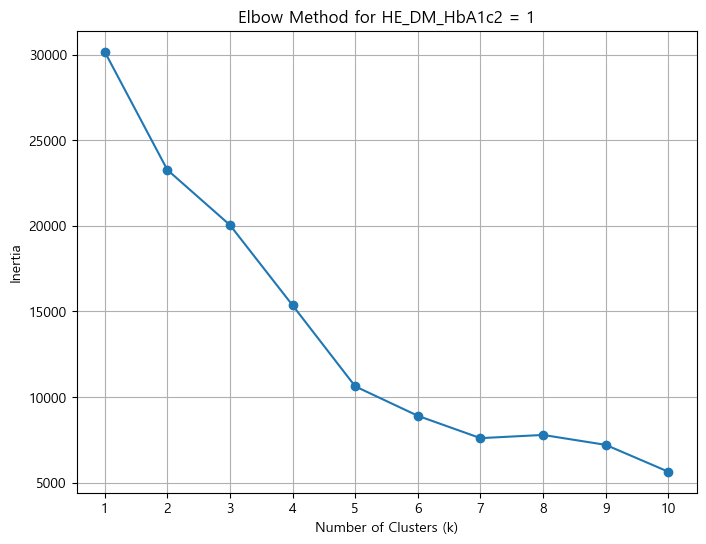

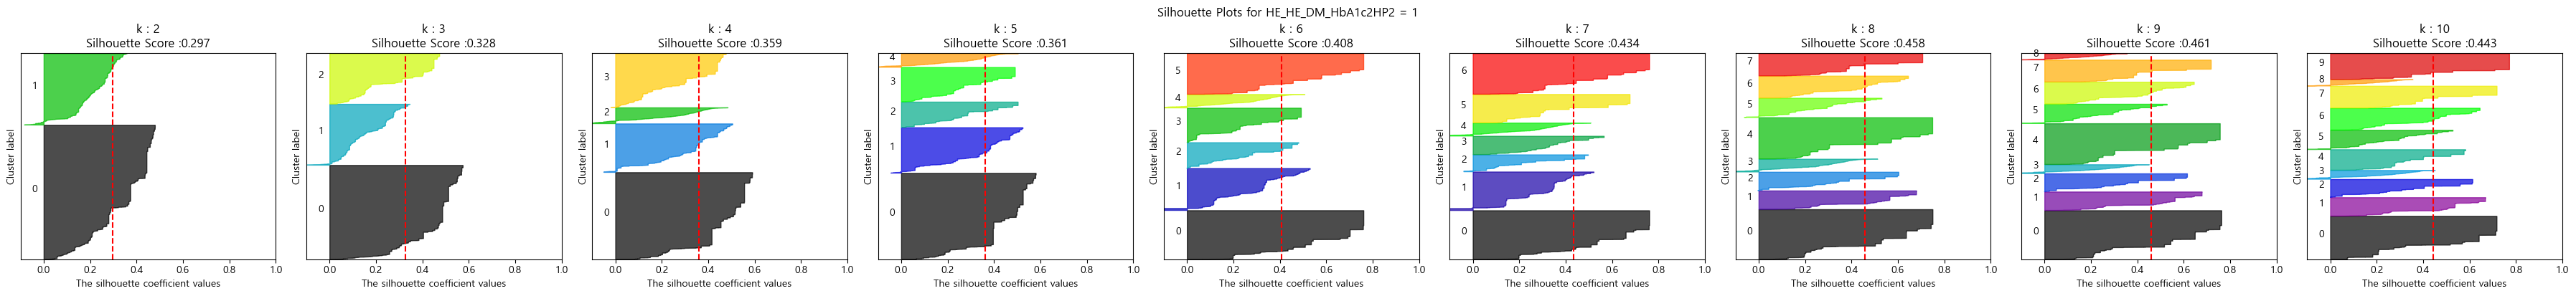


--- Processing HE_DM_HbA1c2 = 2 ---


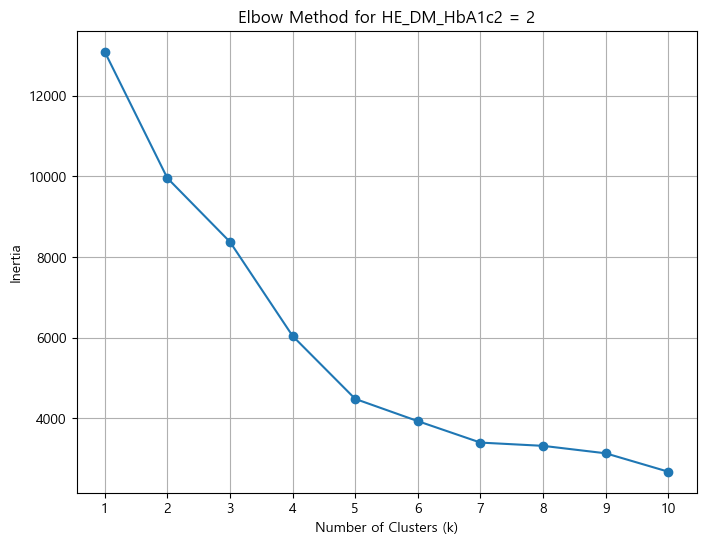

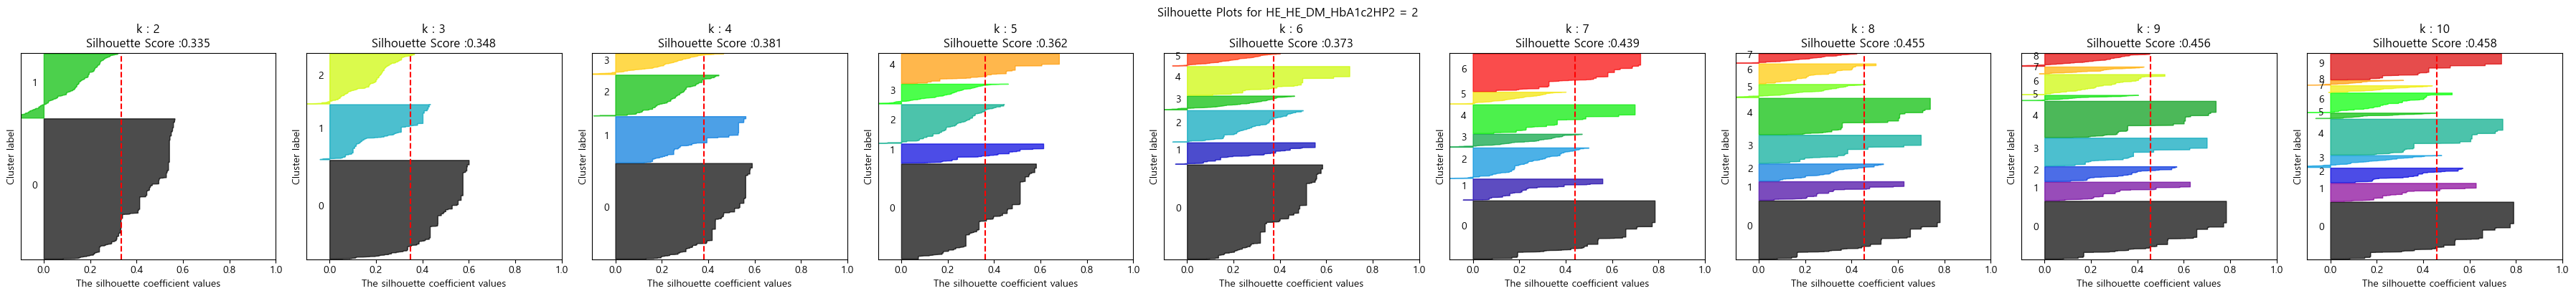


--- Processing HE_DM_HbA1c2 = 3 ---


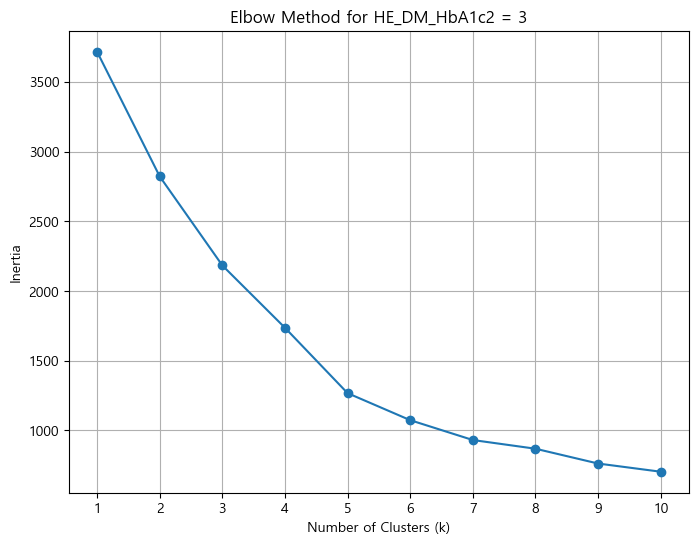

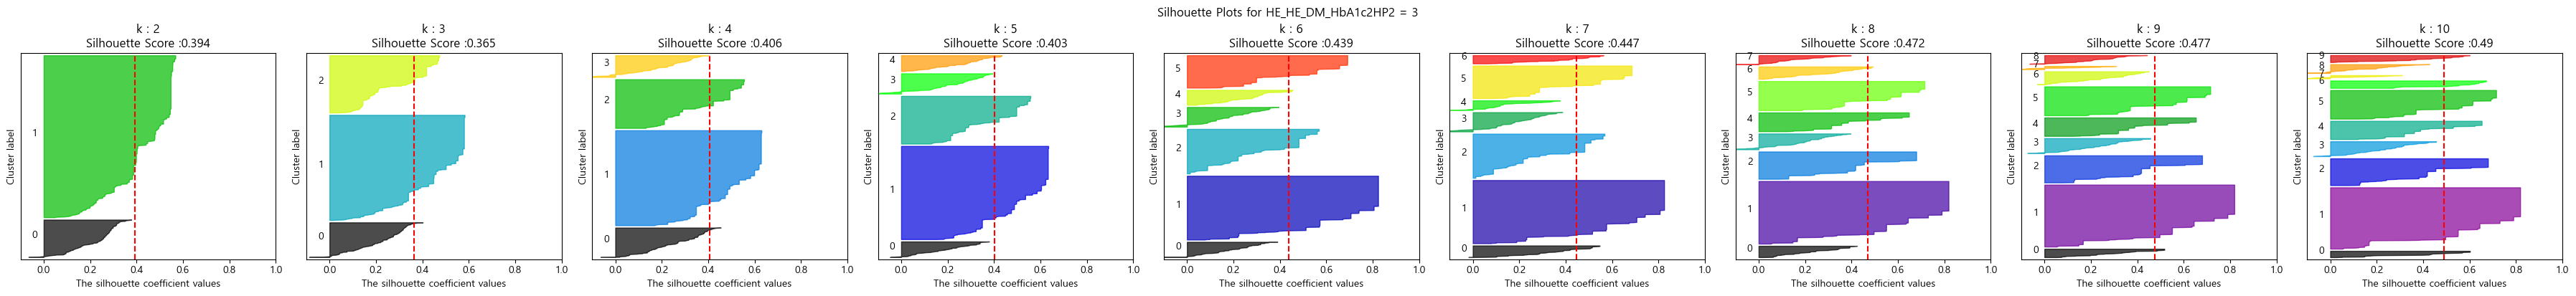


--- Processing complete ---


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans # KMeans 필요
from sklearn.preprocessing import StandardScaler # StandardScaler 필요
from sklearn.metrics import silhouette_samples, silhouette_score # silhouette_samples, silhouette_score 임포트 추가

# Assume df_clustering and knn_columns are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# knn_columns = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'] # 실제 knn_columns 목록


# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (엘보우 및 실루엣 시각화에 사용할 최대 k)
k_range_max = 10 # 최대 10개 클러스터까지 탐색

# 결과를 저장할 데이터프레임 준비
# 'Cluster' 칼럼이 이미 있다면 이 줄은 필요 없을 수 있습니다.
# df_clustering['Cluster'] = np.nan

# 군집 분석에 사용할 피처 목록 정의
# knn_columns와 추가 피처들을 결합합니다.
try:
    selected_cols =['BE3_31','BD1_11', 'L_BR_FQ', 'tobacco']
    # selected_cols에 포함된 모든 칼럼이 df_clustering에 있는지 확인하는 것이 안전합니다.
    missing_selected_cols = [col for col in selected_cols if col not in df_clustering.columns]
    if missing_selected_cols:
        print(f"Warning: Selected columns not found in df_clustering: {missing_selected_cols}")
        # 데이터에 없는 칼럼은 selected_cols에서 제외하고 진행할 수 있습니다.
        selected_cols = [col for col in selected_cols if col in df_clustering.columns]
        print(f"Using selected_cols found in data: {selected_cols}")

except NameError:
    print("Error: knn_columns is not defined. Please define knn_columns before running this code.")
    # knn_columns가 정의되지 않았을 경우의 예시 selected_cols (실제 사용하실 피처 목록으로 대체하세요)
    selected_cols = ["HE_sbp1", "HE_dbp1", "HE_wc", "HE_glu", "HE_HbA1c", "BD1_11", "tobacco", "BE5_1", "LS_VEG1"]
    print(f"Using example selected_cols: {selected_cols}")

# selected_cols가 비어있으면 분석 진행 불가
if not selected_cols:
    print("Error: selected_cols is empty. Cannot proceed with clustering.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()


# HE_HP 별로 반복
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.
# 실제 df_clustering['HE_HP']의 고유값 리스트를 사용하는 것이 더 안전합니다.
if 'HE_DM_HbA1c2' not in df_clustering.columns:
    print("Error: 'HE_DM_HbA1c2' column not found in df_clustering. Cannot perform clustering by HE_HP.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()

# HE_HP의 실제 고유값 가져오기 및 정렬
he_hp_values = sorted(df_clustering['HE_DM_HbA1c2'].dropna().unique().tolist())
# 만약 특정 HE_HP 값만 분석하고 싶다면 아래 리스트를 사용
# he_hp_values_to_process = [1, 2, 3, 4] # 분석할 HE_HP 값 목록

for hp_value in he_hp_values: # 실제 HE_HP 고유값 사용
    print(f"\n--- Processing HE_DM_HbA1c2 = {hp_value} ---")

    # HE_HP 값에 해당하는 데이터 추출
    # selected_cols에 해당하는 칼럼만 선택합니다.
    hp_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 데이터 표준화
        # 각 그룹별로 별도의 scaler를 fit/transform 합니다.
        scaled_df = scaler.fit_transform(hp_df)

        # 클러스터 개수가 데이터 포인트 개수보다 많을 수는 없으므로 범위를 조정
        # 또한, 실루엣 계수 등 다른 검증 지표를 사용하려면 k>1 이어야 합니다.
        max_k_current_group = min(len(scaled_df), k_range_max) # 현재 그룹 데이터 개수와 최대 범위 중 작은 값

        if max_k_current_group < 2:
             print(f" Not enough data points ({len(scaled_df)}) for HE_DM_HbA1c2 = {hp_value} to perform clustering for k > 1.")
             continue # 다음 HE_HP 값으로 넘어감


        # --- 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 ---
        # 관성을 계산할 k 범위 (최소 1부터 시작)
        k_range_inertia = range(1, max_k_current_group + 1)
        inertias = []
        for k in k_range_inertia:
            # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
            # k=1일때는 n_init=1로 설정 가능
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range_inertia, inertias, marker='o')
        plt.title(f'Elbow Method for HE_DM_HbA1c2 = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range_inertia) # x축 틱을 k 범위로 설정
        plt.grid(True)
        plt.show()

        # --- 실루엣 계수 시각화 ---
        # 실루엣 계수를 계산할 k 범위 (최소 2부터 시작)
        k_range_silhouette = range(2, max_k_current_group + 1)

        if len(k_range_silhouette) > 0: # k_range_silhouette가 비어있지 않을 때만 시각화
            n_cols = len(k_range_silhouette)

            # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
            # squeeze=False를 사용하여 n_cols=1일 때도 axs가 항상 2D 배열이 되도록 합니다.
            fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
            axs = axs.reshape(-1) # 1D 배열로 평탄화

            # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
            for ind, n_cluster in enumerate(k_range_silhouette):
                ax = axs[ind] # 각 서브플롯 선택

                try:
                    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
                    # n_init='auto' 또는 숫자로 지정 필요
                    clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
                    cluster_labels = clusterer.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # 데이터 포인트가 1개보다 많고 클러스터 개수가 1개보다 많을 때만 계산 가능
                    if len(np.unique(cluster_labels)) > 1 and scaled_df.shape[0] > 1:
                         sil_avg = silhouette_score(scaled_df, cluster_labels)
                         sil_values = silhouette_samples(scaled_df, cluster_labels)
                    else:
                         sil_avg = 0 # 계산 불가 시 0 또는 NaN으로 처리
                         sil_values = np.zeros(scaled_df.shape[0]) # 모든 샘플 점수 0으로 처리
                         print(f" Silhouette score not computable for k={n_cluster} (less than 2 clusters or data points).")


                    y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

                    # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
                    ax.set_title('k : ' + str(n_cluster)+'\n' \
                                 'Silhouette Score :' + str(round(sil_avg,3)) )
                    ax.set_xlabel("The silhouette coefficient values")
                    ax.set_ylabel("Cluster label")
                    ax.set_xlim([-0.1, 1]) # x축 범위 설정
                    # y축 범위 설정: 데이터 포인트 총 수 + (클러스터 개수 + 1) * 클러스터 간 간격
                    ax.set_ylim([0, len(scaled_df) + (n_cluster + 1) * 10])
                    ax.set_yticks([])  # yaxis labels / ticks 제거
                    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

                    # 각 클러스터별 실루엣 플롯 그리기
                    # 클러스터 라벨 순서대로 정렬하여 그립니다.
                    unique_labels = np.unique(cluster_labels)
                    unique_labels.sort() # 라벨을 오름차순으로 정렬하여 일관성 확보

                    for i in unique_labels: # 정렬된 고유 라벨 순회
                        # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                        ith_cluster_sil_values = sil_values[cluster_labels == i]
                        ith_cluster_sil_values.sort() # 점수 정렬

                        size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                        y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                        # 클러스터 색상 설정
                        color = cm.nipy_spectral(float(i) / len(unique_labels)) # 고유 라벨 개수로 색상 스케일링
                        # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                        ax.fill_betweenx(np.arange(y_lower, y_upper),
                                         0, ith_cluster_sil_values,
                                         facecolor=color, edgecolor=color, alpha=0.7)

                        # 클러스터 번호 텍스트 추가
                        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                        # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                        y_lower = y_upper + 10 # 클러스터 간 간격 추가

                    # 평균 실루엣 점수 라인 추가
                    ax.axvline(x=sil_avg, color="red", linestyle="--")

                except Exception as e:
                    print(f" Error visualizing silhouette for k={n_cluster}: {e}")
                    ax.set_title(f'k={n_cluster} (Error)')
                    ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                    ax.set_xticks([])
                    ax.set_yticks([])

            # 전체 플롯 레이아웃 조정 및 제목 추가
            plt.tight_layout()
            plt.suptitle(f'Silhouette Plots for HE_HE_DM_HbA1c2HP2 = {hp_value}', y=1.02) # 전체 제목에 HE_HP 값 포함
            plt.show()

        else:
            print(f"  Not enough data points ({len(scaled_df)}) for HE_DM_HbA1c2 = {hp_value} to perform clustering for k > 1 for silhouette visualization.")



    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_DM_HbA1c2 = {hp_value} to perform clustering.")
        # 데이터가 없거나 부족하면 해당 HE_HP 값에 대한 클러스터 라벨을 NaN으로 유지
        # df_clustering.loc[hp_df.index, 'Cluster'] = np.nan # 이미 초기화 시 np.nan 이므로 필요 없을 수 있습니다.


print("\n--- Processing complete ---")

# 루프가 완료된 후, df_clustering 데이터프레임에는 각 HE_HP 그룹에 대해
# 결정된 optimal_k로 군집화된 'Cluster' 라벨이 추가되어 있습니다.
# 이제 이 df_clustering를 사용하여 군집별 특징 분석, 시각화 등을 수행할 수 있습니다.


3개 방법 비교 


--- Processing HE_DM_HbA1c2 = 1 with k = 6 ---
Comparing algorithms for k = 6:
 - KMeans: Silhouette Score = 0.4177
 - Agglomerative: Silhouette Score = 0.3872
 - MiniBatchKMeans: Silhouette Score = 0.4130

Best algorithm for HE_DM_HbA1c2 = 1 (k=6): KMeans (Silhouette Score: 0.4177)
Cluster Characteristics (Mean values for HE_DM_HbA1c2 = 1, k=6) - Modified:
              1년간 음주 빈도  하루 평균 흡연량  1주일간 걷기 일수  1주 동안 아침식사 빈도
New_Cluster                                                  
0             88.943144   0.939799    5.975753       0.624582
1             15.055435   0.343478    6.186957       5.631793
2             13.004450   0.311507    1.010807       5.615385
3            191.983573   0.526352    4.457221       5.460643
4            107.074074  19.549383    3.576132       3.248971
5             69.839594   0.928934    0.986802       0.667005
------------------------------------------------------------


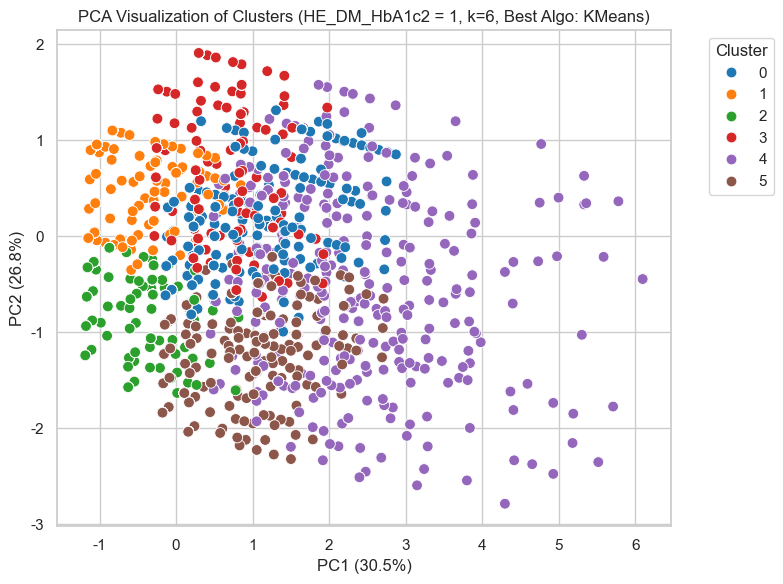


--- Processing HE_DM_HbA1c2 = 2 with k = 5 ---
Comparing algorithms for k = 5:
 - KMeans: Silhouette Score = 0.4140
 - Agglomerative: Silhouette Score = 0.3442
 - MiniBatchKMeans: Silhouette Score = 0.4142

Best algorithm for HE_DM_HbA1c2 = 2 (k=5): MiniBatchKMeans (Silhouette Score: 0.4142)
Cluster Characteristics (Mean values for HE_DM_HbA1c2 = 2, k=5) - Modified:
              1년간 음주 빈도  하루 평균 흡연량  1주일간 걷기 일수  1주 동안 아침식사 빈도
New_Cluster                                                  
0            185.203438   0.932665    4.620344       5.781519
1             20.503748   0.434783    1.070465       5.603448
2             96.214173   1.611024    3.908661       0.577165
3             12.645570   0.353376    6.274262       5.783755
4            115.395062  19.583333    3.620370       3.643519
------------------------------------------------------------


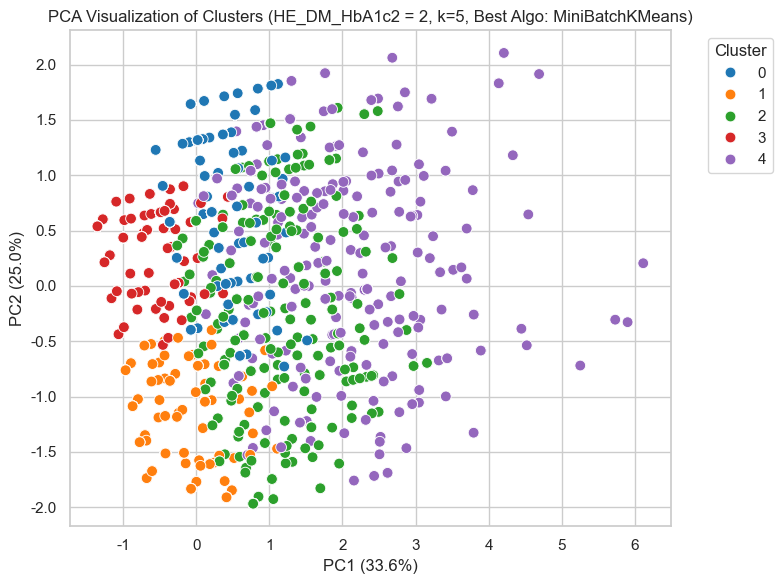


--- Processing HE_DM_HbA1c2 = 3 with k = 6 ---
Comparing algorithms for k = 6:
 - KMeans: Silhouette Score = 0.4604
 - Agglomerative: Silhouette Score = 0.4273
 - MiniBatchKMeans: Silhouette Score = 0.4398

Best algorithm for HE_DM_HbA1c2 = 3 (k=6): KMeans (Silhouette Score: 0.4604)
Cluster Characteristics (Mean values for HE_DM_HbA1c2 = 3, k=6) - Modified:
              1년간 음주 빈도  하루 평균 흡연량  1주일간 걷기 일수  1주 동안 아침식사 빈도
New_Cluster                                                  
0             11.213793   0.475862    1.268966       5.775862
1             70.652174   5.065217    3.920290       0.510870
2            177.574468   0.652482    6.127660       5.673759
3              9.812903   0.151613    6.280645       5.870968
4             98.680412  22.226804    3.639175       5.237113
5            181.734694   1.020408    1.306122       5.658163
------------------------------------------------------------


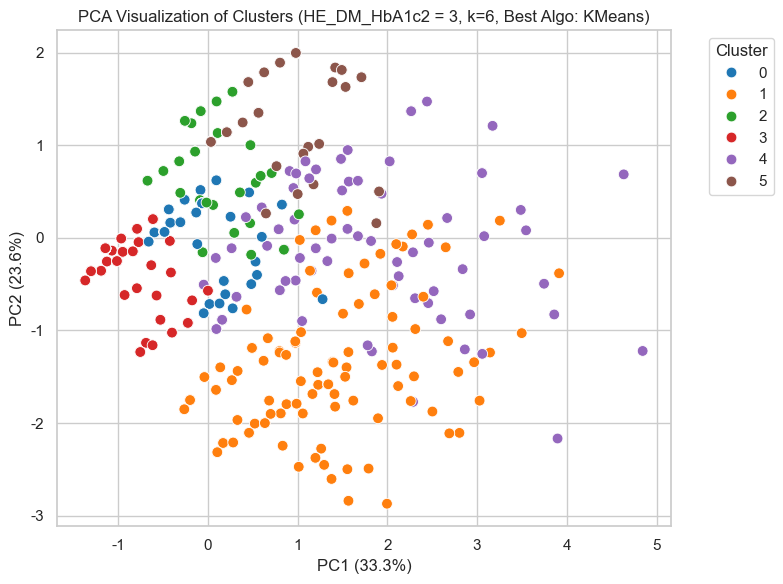


--- Processing complete ---


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루 평균 흡연량', # 이 피처가 selected_cols에 있는지 확인 필요
    'BE3_31' : '1주일 간 걷기 일수',
    'L_BR_FQ': '1주 동안 아침식사 빈도',
    # selected_cols에 포함된 다른 피처들도 여기에 추가해야 합니다.
    'age': '나이', 'sex': '성별', 'HE_HbA1c': '당화혈색소', # 예시 추가
    # ... selected_cols에 있는 모든 피처에 대한 매핑 추가 ...
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1', 'age', 'sex', 'HE_HbA1c'] # 실제 selected_cols 목록
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# MiniBatchKMeans 추가
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans, # MiniBatchKMeans 추가
    # DBSCAN은 n_clusters 대신 다른 매개변수를 사용하므로 이 비교 루프에서는 제외합니다.
}


# HE_HP 별로 반복
# optimal_k 리스트는 각 HE_HP 값에 대해 미리 결정되어 있어야 합니다.
# 예: optimal_k_list = [3, 5, 5, 5]
# HE_HP_values = [1, 2, 3, 4] # 실제 HE_HP 고유값
# for hp_value, optimal_k in zip(HE_HP_values, optimal_k_list):

for hp_value, optimal_k in zip([1, 2, 3], [6, 5, 6]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_DM_HbA1c2 = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    hp_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(hp_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f" - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f" - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f" - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_DM_HbA1c2 = {hp_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_DM_HbA1c2 = {hp_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산 (원본 스케일)
        cluster_characteristics_original = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # --- 출력 테이블을 위한 데이터 변환 및 컬럼 이름 변경 ---
        # '1년 간 음주 빈도'를 '1주일 간 음주 빈도'로 (평균 / 52)
        weekly_alcohol = cluster_characteristics_original['BD1_11']

        

        # 나머지 피처는 그대로 사용
        daily_smoking = cluster_characteristics_original['tobacco']
        weekly_exercise = cluster_characteristics_original['BE3_31']
        daily_veg = cluster_characteristics_original['L_BR_FQ']
        
        

        # 새로운 컬럼 이름으로 결과 데이터프레임 생성
        output_characteristics = pd.DataFrame({
            '1년간 음주 빈도': weekly_alcohol,
            '하루 평균 흡연량': daily_smoking,
            '1주일간 걷기 일수': weekly_exercise,
            '1주 동안 아침식사 빈도': daily_veg
        })

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_DM_HbA1c2 = {hp_value}, k={optimal_k}) - Modified:")
        print(output_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용 (원본 selected_cols 기준)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_HP 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_DM_HbA1c2 = {hp_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_DM_HbA1c2 = {hp_value} to perform clustering.")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")


[최종]

사용자의 생활습관 수치를 입력해주세요.

홍길동님은 공복혈당 99.0를 고려했을 때 HE_DM_HbA1c2 = 1, 정상에 속합니다.
1주일 간 음주 빈도, 하루 평균 흡연량, 1주일 간 걷기 일수, 1주 동안 아침식사 빈도를 고려했을 때 정상에서 1번 군집에 속합니다.

✅ 사용자 생활습관 vs 군집 평균 비교:
| 항목                   |   홍길동님 수치 |   군집 1 평균 수치 |
|:-----------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도     |            3.00 |               3.70 |
| 하루 평균 흡연량       |            2.00 |               1.92 |
| 1주일 간 걷기 일수     |            5.00 |               4.47 |
| 1주 동안 아침식사 빈도 |            4.00 |               4.64 |


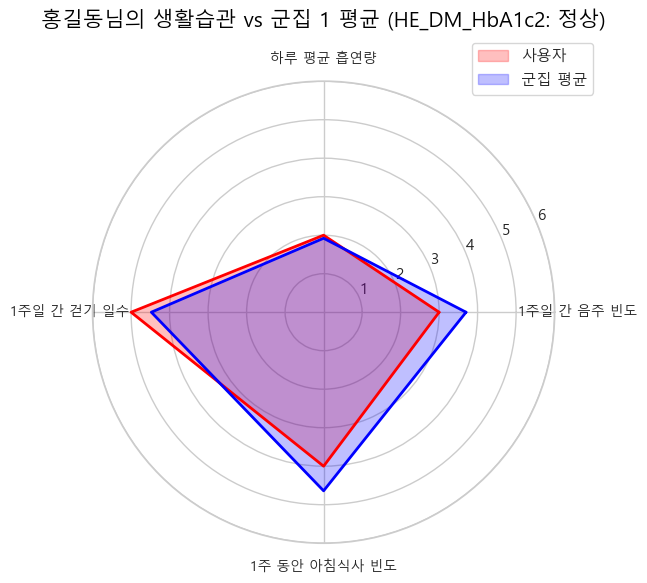

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import pi

# 시각화 설정 (한글 폰트 및 음수 표시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 환경에서 맑은 고딕 설정
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
# 실제 데이터 파일 경로로 수정 필요
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

# 전처리: BE3_31 (1주일 간 걷기 일수)
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
    '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
})
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리: L_BR_FQ (최근 1년 동안 1주 동안 아침식사 빈도)
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주 빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 당뇨 파생변수 생성 (HE_DM_HbA1c2)
def classify_bp(row):
    glu = row['HE_glu']
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

df['HE_DM_HbA1c2'] = df.apply(classify_bp, axis=1)
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_DM_HbA1c2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering[col].fillna(mode_value[0], inplace=True)
        else:
            df_clustering[col].fillna(0, inplace=True)

# 사전 계산된 군집 평균 데이터 (HE_DM_HbA1c2 기준)
# 실제 데이터가 없으므로, 사용자 요청에 따라 임의로 설정 (실제 데이터로 대체 필요)
import pandas as pd

# The updated precalculated_means dictionary including HE_DM_HbA1c2 = 3

precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.679037, 3.699045, 0.205307, 0.495192, 1.637577, 0.247029],
        '하루 평균 흡연량': [0.883784, 1.920382, 0.305901, 0.764344, 19.815618, 0.317173],
        '1주일 간 걷기 일수': [6.015315, 4.474522, 1.086957, 1.079918, 3.561822, 6.187346],
        '1주 동안 아침식사 빈도': [0.591892, 4.639331, 5.596273, 0.627049, 3.206074, 5.622021]
    }, index=[0, 1, 2, 3, 4, 5]), # k=6 for HE_DM_HbA1c2=1
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.467910, 0.868637, 1.435988, 5.500000, 0.474998],
        '하루 평균 흡연량': [0.438253, 1.461412, 19.321555, 5.978166, 0.407047],
        '1주일 간 걷기 일수': [6.262048, 3.768473, 3.653710, 3.890830, 1.222357],
        '1주 동안 아침식사 빈도': [5.800452, 0.623974, 3.793286, 4.109170, 5.717497]
    }, index=[0, 1, 2, 3, 4]), # k=5 for HE_DM_HbA1c2=2
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.365672, 0.374903, 1.797498, 0.454709, 2.443396, 4.320225],
        '하루 평균 흡연량': [0.492537, 0.199495, 21.493976, 0.953271, 19.056604, 1.000000],
        '1주일 간 걷기 일수': [1.223881, 6.353535, 3.795181, 3.943925, 3.622642, 3.662921],
        '1주 동안 아침식사 빈도': [5.763682, 5.886364, 5.879518, 0.668224, 1.179245, 5.382022]
    }, index=[0, 1, 2, 3, 4, 5]) # k=6 for HE_DM_HbA1c2=3
}

# 사용자 입력 함수
def get_user_input():
    print("사용자의 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    glu = float(input("공복혈당 (mg/dL): "))
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (일): "))
    daily_veg = float(input("1주 동안 아침식사 빈도 (회): "))
    return name, glu, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg

# HE_DM_HbA1c2 결정 함수
def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

# 군집 결정 함수 (사전 계산된 평균 사용)
def determine_cluster_with_precalculated_means(user_data_weekly_daily, dm_value, scaler, precalculated_means_dict, selected_cols):
    dm_value_int = int(dm_value)

    if dm_value_int not in precalculated_means_dict:
        print(f"사전 계산된 군집 평균 데이터에 HE_DM_HbA1c2={dm_value_int} 그룹이 없습니다.")
        return None, None

    cluster_means_precalculated_text_names = precalculated_means_dict[dm_value_int].copy()

    # 텍스트 이름과 내부 컬럼 이름 매핑
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '1주 동안 아침식사 빈도': 'L_BR_FQ'
    }

    # 내부 컬럼명으로 DataFrame 생성 (selected_cols 순서 유지)
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)
        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            print(f"경고: 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.")
            cluster_means_precalculated_internal_names[internal_col] = np.nan

    if cluster_means_precalculated_internal_names.isnull().values.any():
        print("경고: 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")
        return None, None

    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols])

    # 사용자 데이터를 군집 분석 특성 형식으로 변환
    user_data_transformed_for_predict = [
        user_data_weekly_daily[0] * 52,  # 주간 음주 -> 연간 음주
        user_data_weekly_daily[1],       # 하루 흡연
        user_data_weekly_daily[2],       # 주간 걷기
        user_data_weekly_daily[3]        # 아침식사
    ]

    user_data_scaled_for_predict = scaler.transform([user_data_transformed_for_predict])

    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled_for_predict, axis=1)
    closest_cluster = np.argmin(distances)
    cluster_means = precalculated_means_dict[dm_value_int].iloc[closest_cluster]

    return closest_cluster, cluster_means

# 레이더 차트 생성 함수
def plot_radar_chart(user_data_weekly_daily, cluster_mean_weekly_daily, categories, title):
    values_user = user_data_weekly_daily[:]
    values_cluster = cluster_mean_weekly_daily[:]
    all_values = values_user + values_cluster
    max_val = max(all_values) if all_values else 1

    values_user = values_user + values_user[:1]
    values_cluster = values_cluster + values_cluster[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max_val * 1.2)
    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.show()

# 메인 서비스 함수
def health_comparison_service():
    name, glu, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg = get_user_input()
    he_dm_hba1c2 = determine_he_dm_hba1c2(glu)
    he_dm_hba1c2_labels = {1: "정상", 2: "당뇨 전단계", 3: "당뇨"}

    if pd.isna(he_dm_hba1c2):
        print(f"\n공복혈당 수치 ({glu})가 유효하지 않아 HE_DM_HbA1c2 분류를 할 수 없습니다.")
        return

    he_dm_hba1c2_int = int(he_dm_hba1c2)

    if he_dm_hba1c2_int not in precalculated_means:
        print(f"\nHE_DM_HbA1c2 그룹 {he_dm_hba1c2_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return

    print(f"\n{name}님은 공복혈당 {glu}를 고려했을 때 HE_DM_HbA1c2 = {he_dm_hba1c2_int}, {he_dm_hba1c2_labels[he_dm_hba1c2_int]}에 속합니다.")

    hp_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == he_dm_hba1c2_int][selected_cols].copy()

    if hp_df.empty:
        print(f"\nHE_DM_HbA1c2 그룹 {he_dm_hba1c2_int}에 데이터가 없어 비교를 수행할 수 없습니다.")
        return

    scaler = StandardScaler()
    scaler.fit(hp_df[selected_cols])

    user_data_for_cluster_input = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
    cluster, cluster_means_for_comparison = determine_cluster_with_precalculated_means(
        user_data_for_cluster_input, he_dm_hba1c2_int, scaler, precalculated_means, selected_cols
    )

    if cluster is not None:
        print(f"1주일 간 음주 빈도, 하루 평균 흡연량, 1주일 간 걷기 일수, 1주 동안 아침식사 빈도를 고려했을 때 {he_dm_hba1c2_labels[he_dm_hba1c2_int]}에서 {cluster}번 군집에 속합니다.")

        print("\n✅ 사용자 생활습관 vs 군집 평균 비교:")
        user_values = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
        cluster_comp_values = cluster_means_for_comparison.tolist()
        item_names = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주 동안 아침식사 빈도']

        table_data = {
            '항목': item_names,
            f'{name}님 수치': user_values,
            f'군집 {cluster} 평균 수치': cluster_comp_values
        }
        comparison_df = pd.DataFrame(table_data)
        print(comparison_df.to_markdown(index=False, floatfmt=".2f"))

        categories = item_names
        plot_radar_chart(user_values, cluster_comp_values, categories,
                         f"{name}님의 생활습관 vs 군집 {cluster} 평균 (HE_DM_HbA1c2: {he_dm_hba1c2_labels[he_dm_hba1c2_int]})")
    else:
        pass

# 서비스 실행
if __name__ == "__main__":
    health_comparison_service()

C:\Users\82104\AppData\Local\Temp\ipykernel_32048\2470804443.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
C:\Users\82104\AppData\Local\Temp\ipykernel_32048\2470804443.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
C:\Users\82104\AppData\Local\Temp\ipykernel_32048\2470804443.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain 

사용자의 생활습관 수치를 입력해주세요.

홍길동님은 공복혈당 88.0를 고려했을 때 HE_DM_HbA1c2 = 1, **정상**에 속합니다.
1주일 간 음주 빈도, 하루 평균 흡연량, 1주일 간 걷기 일수, 1주 동안 아침식사 빈도를 고려했을 때 **정상** 그룹의 **1**번 군집에 속합니다.

---
## ✅ 더 건강한 그룹 평균과 나 비교하기


c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


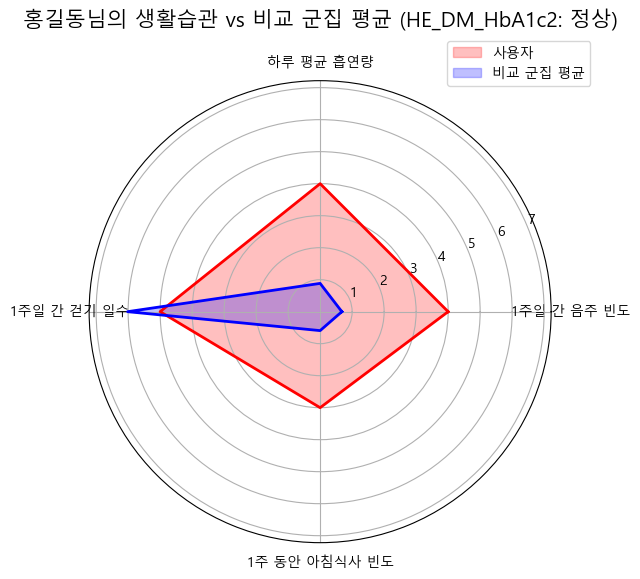


---
## ✅ 사용자 생활습관 vs 비교 군집 평균:
| 항목                   |   홍길동님 수치 |   비교 군집 수치 |
|:-----------------------|----------------:|-----------------:|
| 1주일 간 음주 빈도     |            4.00 |             0.68 |
| 하루 평균 흡연량       |            4.00 |             0.88 |
| 1주일 간 걷기 일수     |            5.00 |             6.02 |
| 1주 동안 아침식사 빈도 |            3.00 |             0.59 |

---

**홍길동**님은 **정상**에 속합니다.
1주일 간 음주 빈도는 **3.32회 줄여야** 합니다.
하루 평균 흡연량은 **3.12개비 줄여야** 합니다.
1주일 간 걷기 일수는 **1.02회 더 늘려야** 합니다.
1주일 간 아침식사 빈도는 **충분합니다.**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import pi

# 시각화 설정 (한글 폰트 및 음수 표시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 환경에서 맑은 고딕 설정
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
# 실제 데이터 파일 경로로 수정 필요
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

# 전처리: BE3_31 (1주일 간 걷기 일수)
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
    '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
})
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리: L_BR_FQ (최근 1년 동안 1주 동안 아침식사 빈도)
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주 빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 당뇨 파생변수 생성 (HE_DM_HbA1c2) - 공복혈당 기준
def classify_blood_glucose(row):
    glu = row['HE_glu']
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1  # 정상
    elif 100 <= glu <= 125:
        return 2  # 당뇨 전단계
    else:
        return 3  # 당뇨

df['HE_DM_HbA1c2'] = df.apply(classify_blood_glucose, axis=1)
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_DM_HbA1c2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering[col].fillna(mode_value[0], inplace=True)
        else:
            df_clustering[col].fillna(0, inplace=True)

# 사전 계산된 군집 평균 데이터 (HE_DM_HbA1c2 기준)
# 실제 데이터가 없으므로, 사용자 요청에 따라 임의로 설정 (실제 데이터로 대체 필요)
precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.679037, 3.699045, 0.205307, 0.495192, 1.637577, 0.247029],
        '하루 평균 흡연량': [0.883784, 1.920382, 0.305901, 0.764344, 19.815618, 0.317173],
        '1주일 간 걷기 일수': [6.015315, 4.474522, 1.086957, 1.079918, 3.561822, 6.187346],
        '1주 동안 아침식사 빈도': [0.591892, 4.639331, 5.596273, 0.627049, 3.206074, 5.622021]
    }, index=[0, 1, 2, 3, 4, 5]),  # k=6 for HE_DM_HbA1c2=1
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.467910, 0.868637, 1.435988, 5.500000, 0.474998],
        '하루 평균 흡연량': [0.438253, 1.461412, 19.321555, 5.978166, 0.407047],
        '1주일 간 걷기 일수': [6.262048, 3.768473, 3.653710, 3.890830, 1.222357],
        '1주 동안 아침식사 빈도': [5.800452, 0.623974, 3.793286, 4.109170, 5.717497]
    }, index=[0, 1, 2, 3, 4]),  # k=5 for HE_DM_HbA1c2=2
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.365672, 0.374903, 1.797498, 0.454709, 2.443396, 4.320225],
        '하루 평균 흡연량': [0.492537, 0.199495, 21.493976, 0.953271, 19.056604, 1.000000],
        '1주일 간 걷기 일수': [1.223881, 6.353535, 3.795181, 3.943925, 3.622642, 3.662921],
        '1주 동안 아침식사 빈도': [5.763682, 5.886364, 5.879518, 0.668224, 1.179245, 5.382022]
    }, index=[0, 1, 2, 3, 4, 5])  # k=6 for HE_DM_HbA1c2=3
}

# 사용자 입력 함수
def get_user_input():
    print("사용자의 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    glu = float(input("공복혈당 (mg/dL): "))
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (일): "))
    daily_breakfast = float(input("1주 동안 아침식사 빈도 (회): "))
    return name, glu, weekly_alcohol, daily_smoking, weekly_exercise, daily_breakfast

# HE_DM_HbA1c2 결정 함수 (기존 classify_bp에서 이름 변경)
def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

# 건강 지표 계산 함수
def calculate_health_score(cluster_mean):
    # Ensure column names match those in precalculated_means DataFrames
    health_score = (
        -cluster_mean['1주일 간 음주 빈도'] * 0.2
        - cluster_mean['하루 평균 흡연량'] * 0.36
        + cluster_mean['1주일 간 걷기 일수'] * 0.28
        + cluster_mean['1주 동안 아침식사 빈도'] * 0.16
    )
    return health_score

# 코사인 유사도 계산 함수
def calculate_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
    return dot_product / (norm_vec1 * norm_vec2)

# 더 건강하고 유사한 군집 선택 함수 (수정됨)
def find_healthier_and_similar_cluster(user_data_raw, user_cluster_means, dm_value_int, precalculated_means_dict):
    if dm_value_int not in precalculated_means_dict:
        return None, None

    cluster_means_all = precalculated_means_dict[dm_value_int]
    health_scores = cluster_means_all.apply(calculate_health_score, axis=1)

    user_cluster_score = calculate_health_score(user_cluster_means)

    # Convert user raw data to the same format as cluster means for similarity calculation
    # BD1_11 (1주일 간 음주 빈도), tobacco (하루 평균 흡연량), BE3_31 (1주일 간 걷기 일수), L_BR_FQ (1주 동안 아침식사 빈도)
    user_data_vector_raw = np.array([
        user_data_raw[0],  # 1주일 간 음주 빈도
        user_data_raw[1],  # 하루 평균 흡연량
        user_data_raw[2],  # 1주일 간 걷기 일수
        user_data_raw[3]   # 1주 동안 아침식사 빈도
    ])

    healthier_and_similar_cluster_index = None
    max_cosine_similarity = -1

    # 먼저 사용자 군집의 건강 점수가 가장 높은지 확인
    if user_cluster_score >= health_scores.max():
        return 'self', user_cluster_means  # 사용자가 속한 군집이 가장 건강하다면 'self' 반환

    for idx in cluster_means_all.index:
        current_cluster_mean = cluster_means_all.loc[idx]
        # Only consider clusters that are healthier
        if health_scores[idx] > user_cluster_score:
            # Ensure the order of features is consistent with user_data_vector_raw
            cluster_mean_vector_raw = current_cluster_mean[[
                '1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주 동안 아침식사 빈도'
            ]].values

            sim = calculate_cosine_similarity(user_data_vector_raw, cluster_mean_vector_raw)

            if sim > max_cosine_similarity:
                max_cosine_similarity = sim
                healthier_and_similar_cluster_index = idx

    if healthier_and_similar_cluster_index is not None:
        return healthier_and_similar_cluster_index, cluster_means_all.loc[healthier_and_similar_cluster_index]
    return None, None

# 군집 결정 함수 (사전 계산된 평균 사용)
def determine_cluster_with_precalculated_means(user_data_weekly_daily, dm_value, scaler, precalculated_means_dict, selected_cols):
    dm_value_int = int(dm_value)

    if dm_value_int not in precalculated_means_dict:
        print(f"사전 계산된 군집 평균 데이터에 HE_DM_HbA1c2={dm_value_int} 그룹이 없습니다.")
        return None, None

    cluster_means_precalculated_text_names = precalculated_means_dict[dm_value_int].copy()

    # 텍스트 이름과 내부 컬럼 이름 매핑
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '1주 동안 아침식사 빈도': 'L_BR_FQ'
    }

    # 내부 컬럼명으로 DataFrame 생성 (selected_cols 순서 유지)
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)
        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            print(f"경고: 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.")
            cluster_means_precalculated_internal_names[internal_col] = np.nan

    if cluster_means_precalculated_internal_names.isnull().values.any():
        print("경고: 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")
        # Handle this case, perhaps by dropping columns with NaNs or filling them
        # For now, let's proceed and assume scaler can handle it if it fits before
        pass

    # Scale the precalculated centroids using the scaler fitted on the relevant data
    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols])

    # Transform user data to match the scaling used for clusters
    user_data_transformed_for_predict = [
        user_data_weekly_daily[0],  # 1주일 간 음주 빈도
        user_data_weekly_daily[1],  # 하루 평균 흡연량
        user_data_weekly_daily[2],  # 1주일 간 걷기 일수
        user_data_weekly_daily[3]   # 1주 동안 아침식사 빈도
    ]
    user_data_scaled_for_predict = scaler.transform([user_data_transformed_for_predict])

    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled_for_predict, axis=1)
    closest_cluster = np.argmin(distances)
    cluster_means = precalculated_means_dict[dm_value_int].iloc[closest_cluster]

    return closest_cluster, cluster_means

# 레이더 차트 생성 함수
def plot_radar_chart(user_data_weekly_daily, compare_cluster_mean_weekly_daily, categories, title):
    values_user = user_data_weekly_daily[:]
    values_cluster = compare_cluster_mean_weekly_daily[:]
    all_values = values_user + values_cluster
    max_val = max(all_values) if all_values else 1

    values_user = values_user + values_user[:1]
    values_cluster = values_cluster + values_cluster[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max_val * 1.2)
    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='비교 군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.show()

# 메인 서비스 함수
def health_comparison_service():
    name, glu, weekly_alcohol, daily_smoking, weekly_exercise, daily_breakfast = get_user_input()
    he_dm_hba1c2 = determine_he_dm_hba1c2(glu)
    he_dm_hba1c2_labels = {1: "정상", 2: "당뇨 전단계", 3: "당뇨"}

    if pd.isna(he_dm_hba1c2):
        print(f"\n공복혈당 수치 ({glu})가 유효하지 않아 HE_DM_HbA1c2 분류를 할 수 없습니다.")
        return

    he_dm_hba1c2_int = int(he_dm_hba1c2)

    if he_dm_hba1c2_int not in precalculated_means:
        print(f"\nHE_DM_HbA1c2 그룹 {he_dm_hba1c2_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return

    #print(f"\n{name}님은 공복혈당 {glu}를 고려했을 때 HE_DM_HbA1c2 = {he_dm_hba1c2_int}, **{he_dm_hba1c2_labels[he_dm_hba1c2_int]}**에 속합니다.")

    # Filter df_clustering based on the determined HE_DM_HbA1c2
    dm_filtered_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == he_dm_hba1c2_int][selected_cols].copy()

    if dm_filtered_df.empty:
        print(f"\nHE_DM_HbA1c2 그룹 {he_dm_hba1c2_int}에 데이터가 없어 비교를 수행할 수 없습니다.")
        return

    scaler = StandardScaler()
    scaler.fit(dm_filtered_df) # Fit scaler on the relevant data for the current HE_DM_HbA1c2 group

    user_data_for_cluster_input = [weekly_alcohol, daily_smoking, weekly_exercise, daily_breakfast]
    current_cluster_index, current_cluster_means = determine_cluster_with_precalculated_means(
        user_data_for_cluster_input, he_dm_hba1c2_int, scaler, precalculated_means, selected_cols
    )

    if current_cluster_index is not None:
        #print(f"1주일 간 음주 빈도, 하루 평균 흡연량, 1주일 간 걷기 일수, 1주 동안 아침식사 빈도를 고려했을 때 **{he_dm_hba1c2_labels[he_dm_hba1c2_int]}** 그룹의 **{current_cluster_index}**번 군집에 속합니다.")

        # 더 건강하고 유사한 군집 찾기
        target_cluster_index, target_cluster_means = find_healthier_and_similar_cluster(
            user_data_for_cluster_input, current_cluster_means, he_dm_hba1c2_int, precalculated_means
        )

        compare_values = []
        comparison_cluster_name = ""
        comparison_title_suffix = ""

        if target_cluster_index is not None and target_cluster_index != 'self':
            print("\n---")
            print("## ✅ 더 건강한 그룹 평균과 나 비교하기")
            compare_values = target_cluster_means.tolist()
            comparison_cluster_name = f'더 건강한 군집 {target_cluster_index} 평균 수치'
            comparison_title_suffix = f" (HE_DM_HbA1c2: {he_dm_hba1c2_labels[he_dm_hba1c2_int]})"

        else: # 사용자가 속한 군집이 가장 건강하거나, 더 나은 군집이 없는 경우
            print(f"\n현재 **{he_dm_hba1c2_labels[he_dm_hba1c2_int]}** 그룹에서 **{name}**님의 군집이 가장 건강하거나, 더 나은 군집이 없습니다. 현재 군집을 기준으로 건강 목표를 설정합니다.")
            compare_values = current_cluster_means.tolist()
            comparison_cluster_name = f'현재 군집 {current_cluster_index} 평균 수치'
            target_cluster_means = current_cluster_means # Set for message generation
            comparison_title_suffix = f" (HE_DM_HbA1c2: {he_dm_hba1c2_labels[he_dm_hba1c2_int]})"


        # 레이더 차트 그리기
        categories = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주 동안 아침식사 빈도']
        plot_radar_chart(user_data_for_cluster_input, compare_values, categories,
                         f"{name}님의 생활습관 vs 비교 군집 평균" + comparison_title_suffix)

        # 비교표 출력
        print("\n---")
        print("## ✅ 사용자 생활습관 vs 비교 군집 평균:")
        user_values = user_data_for_cluster_input

        table_data = {
            '항목': categories,
            f'{name}님 수치': user_values,
            '비교 군집 수치': compare_values
        }
        comparison_df = pd.DataFrame(table_data)
        print(comparison_df.to_markdown(index=False, floatfmt=".2f"))

        # 최종 멘트 출력
        print("\n---")
        print(f"\n**{name}**님은 **{he_dm_hba1c2_labels[he_dm_hba1c2_int]}**에 속합니다.")

        # 음주 빈도 (낮을수록 좋음)
        diff_alcohol = round(user_values[0] - target_cluster_means['1주일 간 음주 빈도'], 2)
        if diff_alcohol > 0:
            print(f"1주일 간 음주 빈도는 **{abs(diff_alcohol)}회 줄여야** 합니다.")
        elif diff_alcohol < 0:
            print(f"1주일 간 음주 빈도는 **{abs(diff_alcohol)}회 낮습니다.**")
        else:
            print("1주일 간 음주 빈도는 **적정합니다.**")

        # 흡연량 (낮을수록 좋음)
        diff_smoking = round(user_values[1] - target_cluster_means['하루 평균 흡연량'], 2)
        if diff_smoking > 0:
            print(f"하루 평균 흡연량은 **{abs(diff_smoking)}개비 줄여야** 합니다.")
        elif diff_smoking < 0:
            print(f"하루 평균 흡연량은 **{abs(diff_smoking)}개비 낮습니다.**")
        else:
            print("하루 평균 흡연량은 **적정합니다.**")

        # 걷기 일수 (높을수록 좋음)
        diff_exercise = round(target_cluster_means['1주일 간 걷기 일수'] - user_values[2], 2)
        if diff_exercise > 0:
            print(f"1주일 간 걷기 일수는 **{abs(diff_exercise)}회 더 늘려야** 합니다.")
        elif diff_exercise < 0:
            print(f"1주일 간 걷기 일수는 **충분합니다.**")
        else:
            print("1주일 간 걷기 일수는 **적정합니다.**")

        # 아침식사 빈도 (높을수록 좋음)
        diff_breakfast = round(target_cluster_means['1주 동안 아침식사 빈도'] - user_values[3], 2)
        if diff_breakfast > 0:
            print(f"1주일 간 아침식사 빈도는 **{abs(diff_breakfast)}회 더 늘려야** 합니다.")
        elif diff_breakfast < 0:
            print(f"1주일 간 아침식사 빈도는 **충분합니다.**")
        else:
            print("1주일 간 아침식사 빈도는 **적정합니다.**")

    else:
        pass

# 서비스 실행
if __name__ == "__main__":
    health_comparison_service()